### 決定木学習とは

決定木学習は 決定木 と呼ばれる 木構造のグラフ を作る機械学習手法です。機械学習の分野では学習手法も単に「決定木」と呼ばれます。


分類にも回帰にも使え、分類の場合3クラス以上の多値分類が可能です。ここでは基本となる分類のみを扱います。


決定木とは
決定木は、属性 と 値 の組｛属性1：値1，属性2：値2, 属性3：値3,…，属性n：値n｝によって表現されたデータを、条件分岐を繰り返すことであるクラスに割り当てることができる木構造のグラフです。


以下の例は会場の気温という属性の値によって、開催と中止のクラスに割り当てるグラフです。「会場の気温という属性の値は35以上かどうか」という条件分岐1回による決定木による分類が行えます。例えば36度がこの決定木にインプットされれば、中止というアウトプット（判断）ができます。

#### どう決定木を作るか
決定木の学習には様々なやり方が存在しますが、その中のある方法についてスクラッチを行いながら見ていきます。


学習方法やハイパーパラメータ、訓練データ次第で作られる決定木は異なってきます。

#### 決定木スクラッチ

分類のための決定木のクラスをスクラッチで作成していきます。NumPyなど最低限のライブラリのみを使いアルゴリズムを実装していきます。


決定木の学習には何回まで条件分岐を繰り返すかを表す （最大の）深さ というハイパーパラメータが登場しますが、深さ1の実装を必須課題とします。深さが2以上のものはアドバンス課題とします。


学習の仕方には様々な方法がありますが、ここではscikit-learnでも使用されている CART法 をベースとした実装を行います。この方法では学習の複雑さを減らすために、 分岐は2つに分かれるのみ になります。


以下に雛形を用意してあります。このScratchDecesionTreeClassifierDepth1クラスにコードを書き加えていってください。

In [68]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import math
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
import statistics
from scipy import stats
import collections

In [69]:
class ScratchDecesionTreeClassifierDepth1():
    """
    深さ1の決定木分類器のスクラッチ実装

    Parameters
    ----------
    verbose : bool
      学習過程を出力する場合はTrue
    """
    def __init__(self, verbose=False):
        # ハイパーパラメータを属性として記録
        self.verbose = verbose
        
        
    def fit(self, X, y):
        """
        決定木分類器を学習する
        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            訓練データの特徴量
        y : 次の形のndarray, shape (n_samples, )
            訓練データの正解値
        """
        y_ = y.reshape(-1,1)
        X = np.hstack([X,y_])
       
        ritoku_matrix = np.zeros((X.shape[0],X.shape[1]-1))
        for k in range(X.shape[1]-1):
            for i in range(X.shape[0]):
                #if X[i][k]==np.unique(X[:,k])[0] or X[i][k]==np.unique(X[:,k])[1] or X[i][k]==np.unique(X[:,k])[-1]:
                    #continue
                X_left = X[X[:,k] >= X[i][k]]    # 閾値以上のデータは左ノードにする
                X_right = X[X[:,k] < X[i][k]]    # 閾値未満のノードは右ノードにする
                ritoku_matrix[i][k] = self.information_ritoku(X,X_left,X_right)  #各特徴量でのデータ分の閾値を変えて、利得を算出。ritoku_matrixに格納する。
        
        max_ritoku = np.max(ritoku_matrix)  # 情報利得の最大値を取得
        self.best_data_index = np.unravel_index(np.argmax(ritoku_matrix),ritoku_matrix.shape)[0]     # 情報利得の最大値となるindexを取得
        self.best_feature_column = np.unravel_index(np.argmax(ritoku_matrix),ritoku_matrix.shape)[1] # 情報利得の最大値となるcolumnを取得
        self.best_value = X[self.best_data_index][self.best_feature_column]                          # 情報利得の最大となる閾値
        
        X_left = np.where(X[:,self.best_feature_column] >= self.best_value)   #左ノードのデータのインデックス取得
        self.X_left_lavel = statistics.mode(y[X_left])     #左ノードのデータのラベルの最頻値を取得
        X_right = np.where(X[:,self.best_feature_column] < self.best_value)    #右ノードのデータを取得
        self.X_right_lavel = statistics.mode(y[X_right])         #右ノードのデータのラベルの最頻値を取得
        
        
        if self.verbose: #verboseをTrueにした際は学習過程を出力
            print("最大情報利得：{}".format(max_ritoku))
            print("最大情報利得を与える条件：特徴量の列数{}, その特徴量の閾値{}".format(self.best_feature_column,self.best_value))
            print("左ノードの推定ラベル：{}".format(self.X_left_lavel))
            print("右ノードの推定ラベル：{}".format(self.X_right_lavel))
            
    
    def gini_impurity(self,X):
        
        N_t_all = len(X)
        K = np.unique(X[:,-1]).size
        N_t = np.zeros(K)
        sigma = 0
        for i in range(K):
            N_t[i] = len(X[X[:,-1]==i])
            sigma += (N_t[i] / N_t_all)**2
        I = 1 - sigma
        
        return I
    
    
    def information_ritoku(self,X,X_left,X_right):
        p_gini = self.gini_impurity(X) 
        left_gini = self.gini_impurity(X_left)
        right_gini = self.gini_impurity(X_right)
        
        return p_gini - (len(X_left)/len(X)*left_gini + len(X_right)/len(X)*right_gini)
    
    
    def predict(self, X):
        """
        決定木分類器を使いラベルを推定する
        """
        pred = np.zeros(len(X))        
        
        X_left = np.where(X[:,self.best_feature_column] >= self.best_value)   #左ノードの条件に該当するインデックスを取得
        pred[X_left] = self.X_left_lavel    #左ノードに該当するy_predのインデックスに推定ラベルを代入
        X_right = np.where(X[:,self.best_feature_column] < self.best_value)  #右ノードの条件に該当するインデックスを取得
        pred[X_right] = self.X_right_lavel  #右ノードに該当するy_predのインデックスに推定ラベルを代入
        
        return pred

### 【問題1】不純度を求める関数
ノード の ジニ不純度 を計算する関数を作成してください。ノード $t$ に対するジニ不純度 $I(t)$ は以下の数式で求まります。クラスが混じり合っているほどジニ不純度は高くなります。

```python
def gini_impurity(self,X):
        
        N_t_all = len(X)
        K = np.unique(X[:,-1]).size
        N_t = np.zeros(K)
        sigma = 0
        for i in range(K):
            N_t[i] = len(X[X[:,-1]==i])
            sigma += (N_t[i] / N_t_all)**2
        I = 1 - sigma
        
        return I
```

### 【問題2】情報利得を求める関数
次に、ノード間の 情報利得 を計算する関数を作成してください。問題1で作成したジニ不純度 $I(t)$ を計算する関数を呼び出して使います。情報利得$IG$は以下の数式で求まります。うまく分けられている時ほど情報利得は大きくなります。

ここで分岐は2つのみであるため、分岐先を「左側のノード・右側のノード」と呼びます。

```python
def gini_impurity(self,X):
        
        N_t_all = len(X)
        K = np.unique(X[:,-1]).size
        N_t = np.zeros(K)
        sigma = 0
        for i in range(K):
            N_t[i] = len(X[X[:,-1]==i])
            sigma += (N_t[i] / N_t_all)**2
        I = 1 - sigma
        
        return I
    

def information_ritoku(self,X,X_left,X_right):
        p_gini = self.gini_impurity(X) 
        left_gini = self.gini_impurity(X_left)
        right_gini = self.gini_impurity(X_right)
        
        return p_gini - (len(X_left)/len(X)*left_gini + len(X_right)/len(X)*right_gini)
```

### 【問題3】学習
空間の分割を行い、決定木のグラフを生成するコードを作成してください。今は深さ1の決定木なので、分割を1回だけ行います。ここでグラフを生成するとは、1回の分割の際の条件としてどの特徴量がいくつ以上の時とするかを求めるということです。


訓練データに対して全ての組み合わせの分割を行い、その中でノード間の情報利得が最大となる分割をそのノードの分割基準として記録します。


クラスが混ざらない不純度が0のノード、または指定された深さのノードが 葉ノード となります。葉ノードにはクラスを記録しておき、これを推定時に分類するクラスとします。クラスが混ざらない場合はそのままのクラスを記録し、混ざっている場合は多数決により決めます。

《組み合わせの取り方》


全ての組み合わせの取り方は、最も単純には各特徴量の値自体をしきい値にして分割を行う方法があります。片側の端は今回のスクラッチはこの方法で行なってください。


他には中間の値をしきい値にする方法もあり、scikit-learnではこの方法が用いられています。

《補足》

問題2の情報利得を計算する関数はこの問題3で利用する上では、親ノードの不純度 $I(p)$ は固定されるため、左右のノードの不純度の合計を計算するだけでも同じ結果が得られることになります。しかし、ここでは親ノードを考慮した情報利得を計算する実装を行なってください。

```python
def fit(self, X, y):
        """
        決定木分類器を学習する
        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            訓練データの特徴量
        y : 次の形のndarray, shape (n_samples, )
            訓練データの正解値
        """
        y_ = y.reshape(-1,1)
        X = np.hstack([X,y_])
       
        ritoku_matrix = np.zeros((X.shape[0],X.shape[1]-1))
        for k in range(X.shape[1]-1):
            for i in range(X.shape[0]):
                #if X[i][k]==np.unique(X[:,k])[0] or X[i][k]==np.unique(X[:,k])[1] or X[i][k]==np.unique(X[:,k])[-1]:
                    #continue
                X_left = X[X[:,k] >= X[i][k]]    # 閾値以上のデータは左ノードにする
                X_right = X[X[:,k] < X[i][k]]    # 閾値未満のノードは右ノードにする
                ritoku_matrix[i][k] = self.information_ritoku(X,X_left,X_right)  #各特徴量でのデータ分の閾値を変えて、利得を算出。ritoku_matrixに格納する。
        
        max_ritoku = np.max(ritoku_matrix)  # 情報利得の最大値を取得
        self.best_data_index = np.unravel_index(np.argmax(ritoku_matrix),ritoku_matrix.shape)[0]     # 情報利得の最大値となるindexを取得
        self.best_feature_column = np.unravel_index(np.argmax(ritoku_matrix),ritoku_matrix.shape)[1] # 情報利得の最大値となるcolumnを取得
        self.best_value = X[self.best_data_index][self.best_feature_column]                          # 情報利得の最大となる閾値
        
        X_left = np.where(X[:,self.best_feature_column] >= self.best_value)   #左ノードのデータのインデックス取得
        self.X_left_lavel = statistics.mode(y[X_left])     #左ノードのデータのラベルの最頻値を取得
        X_right = np.where(X[:,self.best_feature_column] < self.best_value)    #右ノードのデータを取得
        self.X_right_lavel = statistics.mode(y[X_right])         #右ノードのデータのラベルの最頻値を取得
        
        
        if self.verbose: #verboseをTrueにした際は学習過程を出力
            print("最大情報利得：{}".format(max_ritoku))
            print("最大情報利得を与える条件：特徴量の列数{}, その特徴量の閾値{}".format(self.best_feature_column,self.best_value))
            print("左ノードの推定ラベル：{}".format(self.X_left_lavel))
            print("右ノードの推定ラベル：{}".format(self.X_right_lavel))
```

### 【問題4】推定
推定する仕組みを実装してください。ScratchDecesionTreeClassifierDepth1クラスの雛形に含まれるpredictメソッドに書き加えてください。


入力されたデータの値を学習した条件で判定していき、どの葉ノードに到達するかを見ます。葉ノードにはクラスが記録されているので、これが推定値となります。

```python
def predict(self, X):
        """
        決定木分類器を使いラベルを推定する
        """
        pred = np.zeros(len(X))        
        
        X_left = np.where(X[:,self.best_feature_column] >= self.best_value)   #左ノードの条件に該当するインデックスを取得
        pred[X_left] = self.X_left_lavel    #左ノードに該当するy_predのインデックスに推定ラベルを代入
        X_right = np.where(X[:,self.best_feature_column] < self.best_value)  #右ノードの条件に該当するインデックスを取得
        pred[X_right] = self.X_right_lavel  #右ノードに該当するy_predのインデックスに推定ラベルを代入
        
        return pred
```

### 【問題5】学習と推定
機械学習スクラッチ入門のSprintで用意したシンプルデータセット2の2値分類に対してスクラッチ実装の学習と推定を行なってください。


scikit-learnによる実装と比べ、正しく動いているかを確認してください。


AccuracyやPrecision、Recallなどの指標値はscikit-learnを使用してください。

In [70]:
# シンプルデータセット2

X = np.array([[-0.44699 , -2.8073  ],[-1.4621  , -2.4586  ],
       [ 0.10645 ,  1.9242  ],[-3.5944  , -4.0112  ],
       [-0.9888  ,  4.5718  ],[-3.1625  , -3.9606  ],
       [ 0.56421 ,  0.72888 ],[-0.60216 ,  8.4636  ],
       [-0.61251 , -0.75345 ],[-0.73535 , -2.2718  ],
       [-0.80647 , -2.2135  ],[ 0.86291 ,  2.3946  ],
       [-3.1108  ,  0.15394 ],[-2.9362  ,  2.5462  ],
       [-0.57242 , -2.9915  ],[ 1.4771  ,  3.4896  ],
       [ 0.58619 ,  0.37158 ],[ 0.6017  ,  4.3439  ],
       [-2.1086  ,  8.3428  ],[-4.1013  , -4.353   ],
       [-1.9948  , -1.3927  ],[ 0.35084 , -0.031994],
       [ 0.96765 ,  7.8929  ],[-1.281   , 15.6824  ],
       [ 0.96765 , 10.083   ],[ 1.3763  ,  1.3347  ],
       [-2.234   , -2.5323  ],[-2.9452  , -1.8219  ],
       [ 0.14654 , -0.28733 ],[ 0.5461  ,  5.8245  ],
       [-0.65259 ,  9.3444  ],[ 0.59912 ,  5.3524  ],
       [ 0.50214 , -0.31818 ],[-3.0603  , -3.6461  ],
       [-6.6797  ,  0.67661 ],[-2.353   , -0.72261 ],
       [ 1.1319  ,  2.4023  ],[-0.12243 ,  9.0162  ],
       [-2.5677  , 13.1779  ],[ 0.057313,  5.4681  ]])
y = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=10)

In [71]:
# シンプルデータセット1
import numpy as np
np.random.seed(seed=0)
n_samples = 500
f0 = [-1, 2]
f1 = [2, -1]
cov = [[1.0,0.8], [0.8, 1.0]]
f0 = np.random.multivariate_normal(f0, cov, int(n_samples/2))
f1 = np.random.multivariate_normal(f1, cov, int(n_samples/2))
X = np.concatenate((f0, f1))
y = np.concatenate((np.ones((int(n_samples/2))), np.zeros((int(n_samples/2))))).astype(np.int)
random_index = np.random.permutation(np.arange(n_samples))
X = X[random_index]
y = y[random_index]

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)


In [72]:
Scrach_model = ScratchDecesionTreeClassifierDepth1(verbose=True)
Scrach_model.fit(X_train,y_train)

最大情報利得：0.4232671803278688
最大情報利得を与える条件：特徴量の列数0, その特徴量の閾値0.6683196434757619
左ノードの推定ラベル：0
右ノードの推定ラベル：1


In [73]:
y_pred = Scrach_model.predict(X_test)
print("accuracy_score:{}".format(accuracy_score(y_test,y_pred)))
print("precision_score:{}".format(precision_score(y_test,y_pred)))
print("recall_score:{}".format(recall_score(y_test,y_pred)))
print("f1_score:{}".format(f1_score(y_test,y_pred)))
print("confusion_matrix:\n{}".format(confusion_matrix(y_test,y_pred)))

accuracy_score:0.936
precision_score:0.9206349206349206
recall_score:0.9508196721311475
f1_score:0.9354838709677418
confusion_matrix:
[[59  5]
 [ 3 58]]


In [74]:
from sklearn.tree import DecisionTreeClassifier
sklearn_model = DecisionTreeClassifier(max_depth=1)
sklearn_model.fit(X_train,y_train)
sklearn_y_pred = sklearn_model.predict(X_test)

In [75]:
print("accuracy_score:{}".format(accuracy_score(y_test,sklearn_y_pred)))
print("precision_score:{}".format(precision_score(y_test,sklearn_y_pred)))
print("recall_score:{}".format(recall_score(y_test,sklearn_y_pred)))
print("f1_score:{}".format(f1_score(y_test,sklearn_y_pred)))
print("confusion_matrix:\n{}".format(confusion_matrix(y_test,sklearn_y_pred)))

accuracy_score:0.944
precision_score:0.9354838709677419
recall_score:0.9508196721311475
f1_score:0.943089430894309
confusion_matrix:
[[60  4]
 [ 3 58]]


### 【問題6】決定領域の可視化
決定領域を可視化してください。

In [76]:
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches

def decision_region(X, y, model, step=0.01, title='decision region', xlabel='xlabel', ylabel='ylabel', target_names=['versicolor', 'virginica']):
    """
    2値分類を2次元の特徴量で学習したモデルの決定領域を描く。
    背景の色が学習したモデルによる推定値から描画される。
    散布図の点は訓練データまたは検証データである。

    Parameters
    ----------------
    X : ndarray, shape(n_samples, 2)
        特徴量
    y : ndarray, shape(n_samples,)
        ラベル
    model : object
        学習したモデルのインスンタスを入れる
    step : float, (default : 0.1)
        推定値を計算する間隔を設定する
    title : str
        グラフのタイトルの文章を与える
    xlabel, ylabel : str
        軸ラベルの文章を与える
    target_names= : list of str
        凡例の一覧を与える
    """
    # setting
    scatter_color = ['red', 'blue']
    contourf_color = ['pink', 'skyblue']
    n_class = 2

    # pred
    mesh_f0, mesh_f1  = np.meshgrid(np.arange(np.min(X[:,0])-0.5, np.max(X[:,0])+0.5, step), np.arange(np.min(X[:,1])-0.5, np.max(X[:,1])+0.5, step))
    mesh = np.c_[np.ravel(mesh_f0),np.ravel(mesh_f1)]
    y_pred = model.predict(mesh).reshape(mesh_f0.shape)

    # plot
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.contourf(mesh_f0, mesh_f1, y_pred, n_class-1, cmap=ListedColormap(contourf_color))
    plt.contour(mesh_f0, mesh_f1, y_pred, n_class-1, colors='y', linewidths=3, alpha=0.5)
    for i, target in enumerate(set(y)):
        plt.scatter(X[y==target][:, 0], X[y==target][:, 1], s=80, color=scatter_color[i], label=target_names[i], marker='o')
    patches = [mpatches.Patch(color=scatter_color[i], label=target_names[i]) for i in range(n_class)]
    plt.legend(handles=patches)
    plt.legend()
    plt.show()

Train Data


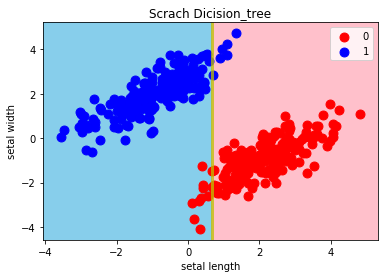

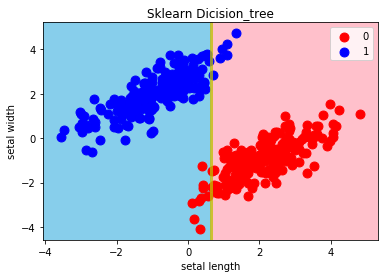

------------------------------------------------
Test Data


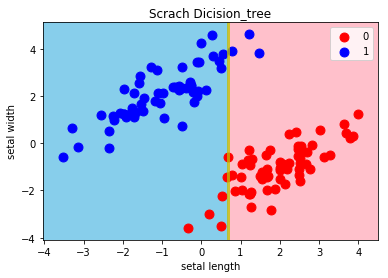

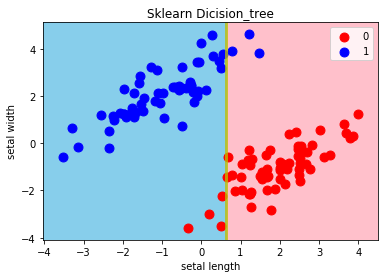

In [77]:
# 学習したそれぞれをtrain data及びtest dataで分けて比較
print("Train Data")
decision_region(X_train, y_train, Scrach_model, step=0.01, title='Scrach Dicision_tree', xlabel='setal length', ylabel='setal width', target_names=['0', '1'])
decision_region(X_train, y_train, sklearn_model, step=0.01, title='Sklearn Dicision_tree', xlabel='setal length', ylabel='setal width', target_names=['0', '1'])
print("------------------------------------------------")
print("Test Data")
decision_region(X_test, y_test, Scrach_model, step=0.01, title='Scrach Dicision_tree', xlabel='setal length', ylabel='setal width', target_names=['0', '1'])
decision_region(X_test, y_test, sklearn_model, step=0.01, title='Sklearn Dicision_tree', xlabel='setal length', ylabel='setal width', target_names=['0', '1'])

**グラフよりほぼ同等の分割ができている事が確認できた。**

### 【問題7】（アドバンス課題）深さ2の決定木分類器クラスの作成
深さが2の決定木分類器のクラスScratchDecesionTreeClassifierDepth2を作成してください。

深さ2とは空間の分割を2回行うことを指します。

《ヒント》
各ノードをインスタンスとして扱うと、任意の深さへの拡張が行いやすくなります。

In [78]:
def calc_impurity(data, labels):
   feature_num = data.shape[1]
   threshold = None
   feature = None
   impurity = 1
   for index in range(feature_num):
       for value in data[:, index]:
           sum_impurity = 0
           # ここではゲインを求める必要がないので不純度と重みの積の和まで求めます
           condition = data[:, index] >= value
           all_samples_num = len(labels)
           for column in [condition, np.logical_not(condition)]:
               I = 1
               partial_samples = labels[column]
               partial_samples_num = len(partial_samples)
               w = partial_samples_num/all_samples_num
               for _class in np.unique(partial_samples):
                   p = np.sum(partial_samples==_class)/partial_samples_num
                   I -= p**2
               sum_impurity += w*I
           # 最小の不純度となるものを記憶します
           if impurity > sum_impurity:
               impurity = sum_impurity
               threshold = value
               feature = index
   return impurity, threshold, feature

# 各ノードで計算は行われるのでノードをクラス化しました
class Node():

   def __init__(self, data, labels, max_depth):
       self.data = data
       self.labels = labels
       self.max_depth = max_depth
       self.children = []
       self.threshold = None
       self.feature = None
       self.depth = None
       self.impurity = None
       self.label = np.argmax(np.bincount(labels))
        
        # CART アルゴリズムの実行部分です
   def cart(self, depth=0):
       self.depth = depth
       self.impurity, self.threshold, self.feature = calc_impurity(self.data, self.labels)
       if self.impurity == 0 or self.depth == self.max_depth:
           return
       condition = self.data[:, self.feature] >= self.threshold
       for column in [condition, np.logical_not(condition)]:
           next_node = Node(self.data[column],  self.labels[column], self.max_depth)
           self.children.append(next_node)
           next_node.cart(self.depth + 1)

   # 予測します、自分が木の端点となるノードなら自分のクラス、子のノードがいるならそのノードの予測結果に委ねます
   def predict(self, data):
       if self.impurity == 0 or self.depth == self.max_depth:
           return self.label
       child_node_index = int(not data[self.feature] >= self.threshold)
       next_node = self.children[child_node_index]
       return next_node.predict(data)


# 決定木クラスです
class DecisionTree():

   # インスタンスを作る際に「最大の深さ」を指定します
   def __init__(self, max_depth):
       self.max_depth = max_depth
       self.tree = None

   # fit(データ, ラベル)とすることでノードクラスを呼び出し、学習します
   def fit(self, data, labels):
       self.tree = Node(data, labels, self.max_depth)
       self.tree.cart()

   # predict(テストデータ)とすることで予測を行います
   def predict(self, data):
       return np.array([self.tree.predict(sample) for sample in data])


In [79]:
# シンプルデータセット2

X = np.array([[-0.44699 , -2.8073  ],[-1.4621  , -2.4586  ],
       [ 0.10645 ,  1.9242  ],[-3.5944  , -4.0112  ],
       [-0.9888  ,  4.5718  ],[-3.1625  , -3.9606  ],
       [ 0.56421 ,  0.72888 ],[-0.60216 ,  8.4636  ],
       [-0.61251 , -0.75345 ],[-0.73535 , -2.2718  ],
       [-0.80647 , -2.2135  ],[ 0.86291 ,  2.3946  ],
       [-3.1108  ,  0.15394 ],[-2.9362  ,  2.5462  ],
       [-0.57242 , -2.9915  ],[ 1.4771  ,  3.4896  ],
       [ 0.58619 ,  0.37158 ],[ 0.6017  ,  4.3439  ],
       [-2.1086  ,  8.3428  ],[-4.1013  , -4.353   ],
       [-1.9948  , -1.3927  ],[ 0.35084 , -0.031994],
       [ 0.96765 ,  7.8929  ],[-1.281   , 15.6824  ],
       [ 0.96765 , 10.083   ],[ 1.3763  ,  1.3347  ],
       [-2.234   , -2.5323  ],[-2.9452  , -1.8219  ],
       [ 0.14654 , -0.28733 ],[ 0.5461  ,  5.8245  ],
       [-0.65259 ,  9.3444  ],[ 0.59912 ,  5.3524  ],
       [ 0.50214 , -0.31818 ],[-3.0603  , -3.6461  ],
       [-6.6797  ,  0.67661 ],[-2.353   , -0.72261 ],
       [ 1.1319  ,  2.4023  ],[-0.12243 ,  9.0162  ],
       [-2.5677  , 13.1779  ],[ 0.057313,  5.4681  ]])
y = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=10)

In [80]:
Scrach_model_2 = DecisionTree(max_depth=2)
Scrach_model_2.fit(X_train,y_train)

In [81]:
y_pred_2 = Scrach_model_2.predict(X_test)
print("accuracy_score:{}".format(accuracy_score(y_test,y_pred_2)))
print("precision_score:{}".format(precision_score(y_test,y_pred_2)))
print("recall_score:{}".format(recall_score(y_test,y_pred_2)))
print("f1_score:{}".format(f1_score(y_test,y_pred_2)))
print("confusion_matrix:\n{}".format(confusion_matrix(y_test,y_pred_2)))

accuracy_score:0.6
precision_score:0.6666666666666666
recall_score:0.4
f1_score:0.5
confusion_matrix:
[[4 1]
 [3 2]]


In [82]:
from sklearn.tree import DecisionTreeClassifier
sklearn_model_2 = DecisionTreeClassifier(max_depth=2)
sklearn_model_2.fit(X_train,y_train)
sklearn_y_pred_2 = sklearn_model_2.predict(X_test)
print("accuracy_score:{}".format(accuracy_score(y_test,sklearn_y_pred_2)))
print("precision_score:{}".format(precision_score(y_test,sklearn_y_pred_2)))
print("recall_score:{}".format(recall_score(y_test,sklearn_y_pred_2)))
print("f1_score:{}".format(f1_score(y_test,sklearn_y_pred_2)))
print("confusion_matrix:\n{}".format(confusion_matrix(y_test,sklearn_y_pred_2)))

accuracy_score:0.7
precision_score:0.75
recall_score:0.6
f1_score:0.6666666666666665
confusion_matrix:
[[4 1]
 [2 3]]


Train Data


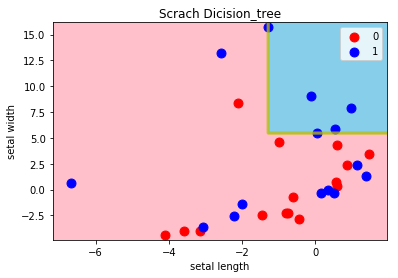

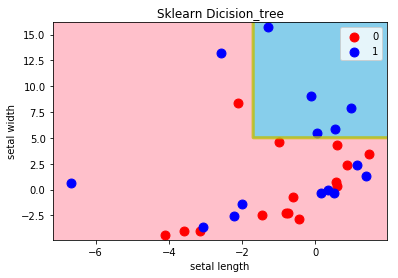

------------------------------------------------
Test Data


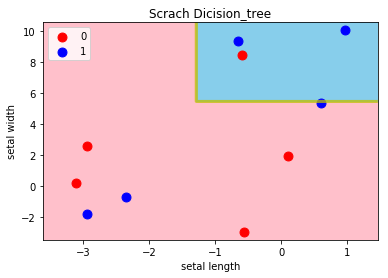

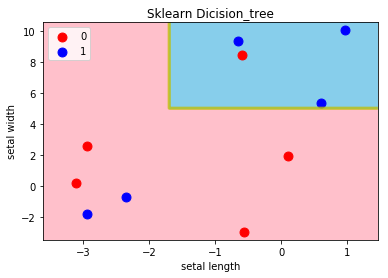

In [83]:
# 学習したそれぞれをtrain data及びtest dataで分けて比較
print("Train Data")
decision_region(X_train, y_train, Scrach_model_2, step=0.01, title='Scrach Dicision_tree', xlabel='setal length', ylabel='setal width', target_names=['0', '1'])
decision_region(X_train, y_train, sklearn_model_2, step=0.01, title='Sklearn Dicision_tree', xlabel='setal length', ylabel='setal width', target_names=['0', '1'])
print("------------------------------------------------")
print("Test Data")
decision_region(X_test, y_test, Scrach_model_2, step=0.01, title='Scrach Dicision_tree', xlabel='setal length', ylabel='setal width', target_names=['0', '1'])
decision_region(X_test, y_test, sklearn_model_2, step=0.01, title='Sklearn Dicision_tree', xlabel='setal length', ylabel='setal width', target_names=['0', '1'])

**深さ２の場合でスクラッチとsklearnでほぼ同等の評価ができている事がわかった。**

### 【問題8】（アドバンス課題）深さに制限のない決定木分類器クラスの作成
深さに制限のない決定木分類器のクラスScratchDecesionTreeClassifierDepthInfを作成してください。


任意の深さを指定できるようにするとともに、指定しない場合は全ての葉ノードがジニ不純度0となるまで続けられるようにもしてください。

目次
Sprint 機械学習スクラッチ 決定木

1.このSprintについて
2.決定木学習とは
3.決定木スクラッチ
4.検証
5.より深い決定木


In [84]:
# 深さ３での確認
Scrach_model_3 = DecisionTree(max_depth=3)
Scrach_model_3.fit(X_train,y_train)

In [85]:
# スクラッチでの評価
y_pred_3 = Scrach_model_3.predict(X_test)
print("accuracy_score:{}".format(accuracy_score(y_test,y_pred_3)))
print("precision_score:{}".format(precision_score(y_test,y_pred_3)))
print("recall_score:{}".format(recall_score(y_test,y_pred_3)))
print("f1_score:{}".format(f1_score(y_test,y_pred_3)))
print("confusion_matrix:\n{}".format(confusion_matrix(y_test,y_pred_3)))

accuracy_score:0.6
precision_score:0.5714285714285714
recall_score:0.8
f1_score:0.6666666666666666
confusion_matrix:
[[2 3]
 [1 4]]


In [86]:
# sklearnでの評価
from sklearn.tree import DecisionTreeClassifier
sklearn_model_3 = DecisionTreeClassifier(max_depth=3)
sklearn_model_3.fit(X_train,y_train)
sklearn_y_pred_3 = sklearn_model_3.predict(X_test)
print("accuracy_score:{}".format(accuracy_score(y_test,sklearn_y_pred_3)))
print("precision_score:{}".format(precision_score(y_test,sklearn_y_pred_3)))
print("recall_score:{}".format(recall_score(y_test,sklearn_y_pred_3)))
print("f1_score:{}".format(f1_score(y_test,sklearn_y_pred_3)))
print("confusion_matrix:\n{}".format(confusion_matrix(y_test,sklearn_y_pred_3)))

accuracy_score:0.7
precision_score:0.625
recall_score:1.0
f1_score:0.7692307692307693
confusion_matrix:
[[2 3]
 [0 5]]


Train Data


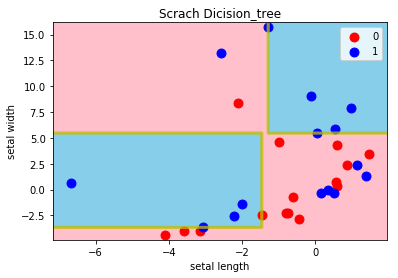

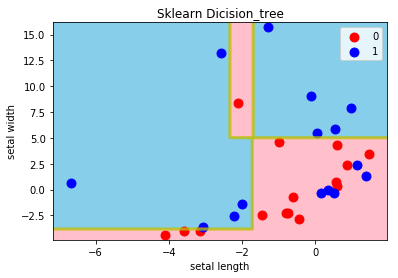

------------------------------------------------
Test Data


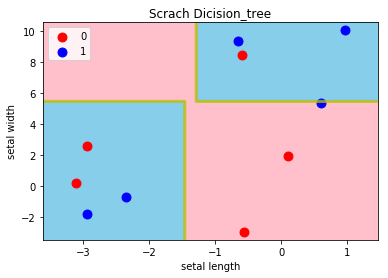

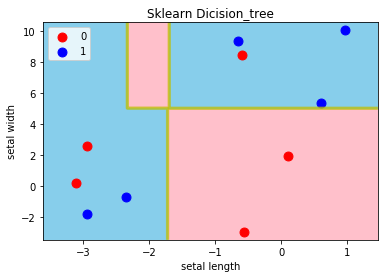

In [87]:
# 学習したそれぞれをtrain data及びtest dataで分けて比較
print("Train Data")
decision_region(X_train, y_train, Scrach_model_3, step=0.01, title='Scrach Dicision_tree', xlabel='setal length', ylabel='setal width', target_names=['0', '1'])
decision_region(X_train, y_train, sklearn_model_3, step=0.01, title='Sklearn Dicision_tree', xlabel='setal length', ylabel='setal width', target_names=['0', '1'])
print("------------------------------------------------")
print("Test Data")
decision_region(X_test, y_test, Scrach_model_3, step=0.01, title='Scrach Dicision_tree', xlabel='setal length', ylabel='setal width', target_names=['0', '1'])
decision_region(X_test, y_test, sklearn_model_3, step=0.01, title='Sklearn Dicision_tree', xlabel='setal length', ylabel='setal width', target_names=['0', '1'])

**深さ３でのスクラッチ評価もsklearnとほぼ同等の評価をできている事がわかった。**

# 参考
```python
class ScratchDecesionTreeClassifierDepth2():
    """
    深さ1の決定木分類器のスクラッチ実装

    Parameters
    ----------
    verbose : bool
      学習過程を出力する場合はTrue
    """
    def __init__(self, max_depth, verbose=False):
        # ハイパーパラメータを属性として記録
        self.verbose = verbose
        self.max_depth = max_depth
        
    def fit(self, X, y):
        """
        決定木分類器を学習する
        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            訓練データの特徴量
        y : 次の形のndarray, shape (n_samples, )
            訓練データの正解値
        """
        
        
        y_ = y.reshape(-1,1)
        X = np.hstack([X,y_])
        self.depth = 0
        
        node_1 = Node(depth=0)
        self.node_1_feature_column, self.node_1_condition, self.node_2_lavel, self.node_3_lavel, node_2_X, node_3_X ,node_2_y, node_3_y = node_1.split(X,y)
        
        self.depth += 1
        
        if self.depth != self.max_depth:
            if len(node_2_X)>2:
                node_2 = Node(depth=1)
                self.node_2_feature_column, self.node_2_condition, self.node_4_lavel, self.node_5_lavel , node_4_X, node_5_X, node_4_y, node_5_y= node_2.split(node_2_X, node_2_y)
    
            if len(node_3_X)>2:
                node_3 = Node(depth=1)
                self.node_3_feature_column, self.node_3_condition, self.node_6_lavel, self.node_7_lavel, node_6_X, node_7_X, node_6_y, node_7_y= node_3.split(node_3_X, node_3_y)
        
        self.depth += 1
        
    def predict(self, X):
    
        pred = np.zeros(len(X))        
        
        
        node_4_index = np.where((X[:,self.node_2_feature_column] >= self.node_2_condition) & (X[:,self.node_1_feature_column] >= self.node_1_condition))   
        pred[node_4_index] = self.node_4_lavel
        
        node_5_index = np.where((X[:,self.node_2_feature_column] < self.node_2_condition) & (X[:,self.node_1_feature_column] >= self.node_1_condition))   
        pred[node_5_index] = self.node_5_lavel
        
        node_6_index = np.where((X[:,self.node_3_feature_column] >= self.node_3_condition) & (X[:,self.node_1_feature_column] < self.node_1_condition))  
        pred[node_6_index] = self.node_6_lavel
        
        node_7_index = np.where((X[:,self.node_3_feature_column] < self.node_3_condition) & (X[:,self.node_1_feature_column] < self.node_1_condition))   
        pred[node_7_index] = self.node_7_lavel
        
        return pred
    
    
    
class Node():
    """
    深さ1の決定木分類器のスクラッチ実装

    Parameters
    ----------
    verbose : bool
      学習過程を出力する場合はTrue
    """
    def __init__(self,depth):
        # ハイパーパラメータを属性として記録
        self.depth = depth
        
        
    def split(self, X, y):
        """
        決定木分類器を学習する
        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            訓練データの特徴量
        y : 次の形のndarray, shape (n_samples, )
            訓練データの正解値
        """
        ritoku_matrix = np.zeros((X.shape[0],X.shape[1]-1))
        for k in range(X.shape[1]-1):
            for i in range(X.shape[0]):
                if X[i][k]==np.unique(X[:,k])[0] or X[i][k]==np.unique(X[:,k])[1] or X[i][k]==np.unique(X[:,k])[-1]:
                    continue
                X_left = X[X[:,k] >= X[i][k]]    # 閾値以上のデータは左ノードにする
                X_right = X[X[:,k] < X[i][k]]    # 閾値未満のノードは右ノードにする
                ritoku_matrix[i][k] = self.information_ritoku(X,X_left,X_right)  #各特徴量でのデータ分の閾値を変えて、利得を算出。ritoku_matrixに格納する。
        
        
        max_ritoku = np.max(ritoku_matrix)  # 情報利得の最大値を取得
        self.best_data_index = np.unravel_index(np.argmax(ritoku_matrix),ritoku_matrix.shape)[0]     # 情報利得の最大値となるindexを取得
        self.best_feature_column = np.unravel_index(np.argmax(ritoku_matrix),ritoku_matrix.shape)[1] # 情報利得の最大値となるcolumnを取得
        self.best_value = X[self.best_data_index][self.best_feature_column]                          # 情報利得の最大となる閾値
        
        #X_left = X[X[:,self.best_feature_column] >= self.best_value] 
        self.X_left = np.where(X[:,self.best_feature_column] >= self.best_value)   #左ノードのデータのインデックス取得
        self.y_left = y[self.X_left]
        self.X_left_lavel = statistics.mode(self.y_left)      #左ノードのデータのラベルの最頻値を取得
        self.X_left = X[X[:,k] >= self.best_value]                            #左ノードのデータを取得
        
        #X_right = X[X[:,self.best_feature_column] < self.best_value]
        self.X_right = np.where(X[:,self.best_feature_column] < self.best_value)   #右ノードのデータを取得
        self.y_right = y[self.X_right]
        self.X_right_lavel = statistics.mode(self.y_right)             #右ノードのデータのラベルの最頻値を取得
        self.X_right = X[X[:,k] < self.best_value]                            #右ノードのデータを取得
        
        #X_left = np.where(X[:,self.best_feature_column] >= self.best_value)   #左ノードのデータのインデックス取得
        #self.X_left_lavel = statistics.mode(y[X_left])     #左ノードのデータのラベルの最頻値を取得
        #X_right = np.where(X[:,self.best_feature_column] < self.best_value)    #右ノードのデータを取得
        #self.X_right_lavel = statistics.mode(y[X_right])         #右ノードのデータのラベルの最頻値を取得
        
        return self.best_feature_column, self.best_value, self.X_left_lavel, self.X_right_lavel, self.X_left, self.X_right, self.y_left, self.y_right
        
        #if self.verbose: #verboseをTrueにした際は学習過程を出力
            #print("最大情報利得：{}".format(max_ritoku))
            #print("最大情報利得を与える条件：特徴量の列数{}, その特徴量の閾値{}".format(self.best_feature_column,self.best_value))
            #print("左ノードの推定ラベル：{}".format(self.X_left_lavel))
            #print("右ノードの推定ラベル：{}".format(self.X_right_lavel))
            
    
    def gini_impurity(self,X):
        
        N_t_all = len(X)
        K = np.unique(X[:,-1]).size
        N_t = np.zeros(K)
        sigma = 0
        for i in range(K):
            N_t[i] = len(X[X[:,-1]==i])
            sigma += (N_t[i] / N_t_all)**2
        I = 1 - sigma
        
        return I
    
    def information_ritoku(self,X,X_left,X_right):
        p_gini = self.gini_impurity(X) 
        left_gini = self.gini_impurity(X_left)
        right_gini = self.gini_impurity(X_right)
        
        return p_gini - (len(X_left)/len(X)*left_gini + len(X_right)/len(X)*right_gini)
```